This notebook visualises rasters and calculates zonal statistics by township.

In [1]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
from sqlalchemy import create_engine
from sqlalchemy import text
import rasterstats
from rasterstats import zonal_stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create a SQLAlchemy engine
conn_string = "postgresql://lizavabistsevits:@localhost:5432/taiwan" # database connection string
engine = create_engine(conn_string)

# Insert township geom into geodataframe
townships = gpd.read_postgis(
    "SELECT code, name, geom FROM townships", 
    engine, 
    geom_col="geom"
)

townships.head(5)

,code,name,geom
0,68000040,Yangmei District,"MULTIPOLYGON (((265128.924 2760180.407, 265142..."
1,64000160,Dashe District,"MULTIPOLYGON (((189599.603 2517612.872, 189596..."
2,64000140,Daliao District,"MULTIPOLYGON (((191951.502 2503292.163, 191940..."
3,64000150,Dashu District,"MULTIPOLYGON (((193966.334 2519114.849, 193954..."
4,64000330,Jiaxian District,"MULTIPOLYGON (((214323.657 2567413.723, 214356..."


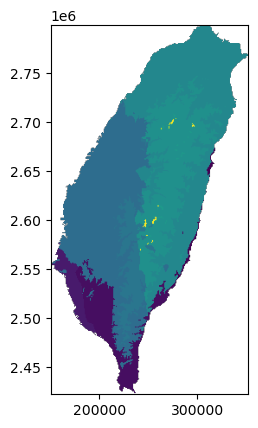

<Axes: >

In [4]:
climate_zones = rasterio.open("../data/koppen_geiger_tif/1991_2020/kg_tw_clipped_3826.tif")
show(climate_zones)

In [7]:
# Calculate zonal statistics for climate zones
zs_cz = zonal_stats(townships, "../data/koppen_geiger_tif/1991_2020/kg_tw_clipped_3826.tif", stats=['majority']) # zonal_stats creates a list of dictionary objects
print(zs_cz)

[{'majority': 14.0}, {'majority': 2.0}, {'majority': 2.0}, {'majority': 2.0}, {'majority': 11.0}, {'majority': 3.0}, {'majority': 3.0}, {'majority': 3.0}, {'majority': 3.0}, {'majority': 14.0}, {'majority': 14.0}, {'majority': 11.0}, {'majority': 11.0}, {'majority': 3.0}, {'majority': 3.0}, {'majority': 3.0}, {'majority': 2.0}, {'majority': 11.0}, {'majority': 2.0}, {'majority': 11.0}, {'majority': 3.0}, {'majority': 12.0}, {'majority': 2.0}, {'majority': 3.0}, {'majority': 2.0}, {'majority': 3.0}, {'majority': 2.0}, {'majority': 14.0}, {'majority': 14.0}, {'majority': 14.0}, {'majority': 14.0}, {'majority': 14.0}, {'majority': 14.0}, {'majority': 14.0}, {'majority': 14.0}, {'majority': None}, {'majority': 3.0}, {'majority': 11.0}, {'majority': 2.0}, {'majority': 11.0}, {'majority': 2.0}, {'majority': 11.0}, {'majority': 2.0}, {'majority': 2.0}, {'majority': 2.0}, {'majority': 11.0}, {'majority': 11.0}, {'majority': 14.0}, {'majority': 14.0}, {'majority': 14.0}, {'majority': 14.0}, {'m

In [8]:
# Create dataframe with zonal statistics
stats_cz = pd.DataFrame(zs_cz)
stats_cz.rename(columns={'majority':'major_climate_zone'}, inplace=True)

# Merge with townships
townships = pd.concat([townships, stats_cz], axis=1)

In [13]:
# Insert elevation into townships table
with engine.begin() as connection:
    for index, row in townships.iterrows():
        query = text("""
            UPDATE townships
            SET main_climate = :climate_zone 
            WHERE code = :township_code
        """)
        connection.execute(query, {"climate_zone": row['major_climate_zone'], "township_code": row['code']})

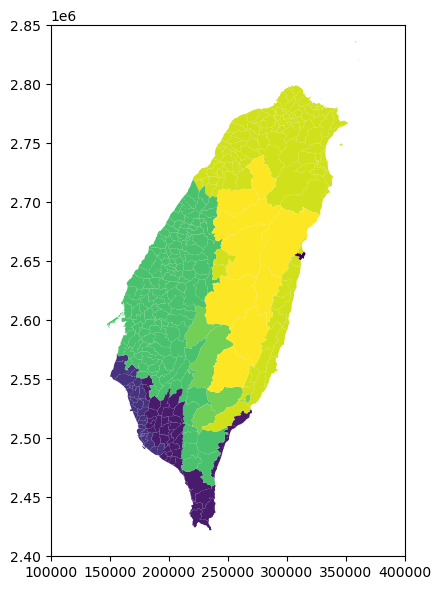

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
townships.plot(column='major_climate_zone', ax=ax)

# Specify coordinates for the plot
ax.set_xlim(100000, 400000)
ax.set_ylim(2400000, 2850000)

plt.tight_layout()
plt.show()

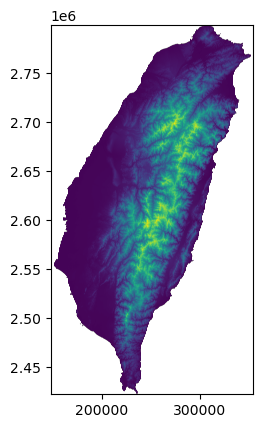

<Axes: >

In [8]:
dem = rasterio.open("../data/elevation/TWN_DEM_3826_Clipped.tif")
show(dem)

In [3]:
# Calculate zonal statistics for elevation (DEM)
zs_dem = zonal_stats(townships, "../data/elevation/TWN_DEM_3826_Clipped.tif", stats=['mean', 'median', 'max'])
print(zs_dem)

[{'max': 387.69000244140625, 'mean': 169.5846566438555, 'median': 158.5500030517578}, {'max': 210.72000122070312, 'mean': 46.3347238776321, 'median': 34.16999816894531}, {'max': 91.83000183105469, 'mean': 18.70846429416337, 'median': 15.429999351501465}, {'max': 247.27999877929688, 'mean': 71.9618007108069, 'median': 60.470001220703125}, {'max': 1668.570068359375, 'mean': 601.71939887576, 'median': 520.510009765625}, {'max': 295.9700012207031, 'mean': 18.776963383537485, 'median': 10.380000114440918}, {'max': 299.0299987792969, 'mean': 30.07757582439951, 'median': 18.475000381469727}, {'max': 26.06999969482422, 'mean': 6.7781961639563075, 'median': 4.809999942779541}, {'max': 69.75, 'mean': 16.58942862904938, 'median': 16.3700008392334}, {'max': 611.0900268554688, 'mean': 93.93186123167331, 'median': 56.5}, {'max': 23.93000030517578, 'mean': 11.869691361460536, 'median': 12.489999771118164}, {'max': 1197.699951171875, 'mean': 481.901010989011, 'median': 440.3699951171875}, {'max': 590.

In [4]:
# Create dataframe with zonal statistics
stats_dem = pd.DataFrame(zs_dem)
stats_dem.rename(columns={'mean':'mean_elevation', 'median':'median_elevation', 'max':'max_elevation'}, inplace=True)

# Merge with townships
townships = pd.concat([townships, stats_dem], axis=1)
townships.head(5)

,code,name,geom,max_elevation,mean_elevation,median_elevation
0,68000040,Yangmei District,"MULTIPOLYGON (((265128.924 2760180.407, 265142...",387.690002,169.584657,158.550003
1,64000160,Dashe District,"MULTIPOLYGON (((189599.603 2517612.872, 189596...",210.720001,46.334724,34.169998
2,64000140,Daliao District,"MULTIPOLYGON (((191951.502 2503292.163, 191940...",91.830002,18.708464,15.429999
3,64000150,Dashu District,"MULTIPOLYGON (((193966.334 2519114.849, 193954...",247.279999,71.961801,60.470001
4,64000330,Jiaxian District,"MULTIPOLYGON (((214323.657 2567413.723, 214356...",1668.570068,601.719399,520.510010


In [5]:
# Insert elevation into townships table
with engine.begin() as connection:
    for index, row in townships.iterrows():
        query = text("""
            UPDATE townships
            SET elevation = :elevation 
            WHERE code = :township_code
        """)
        connection.execute(query, {"elevation": row['mean_elevation'], "township_code": row['code']})

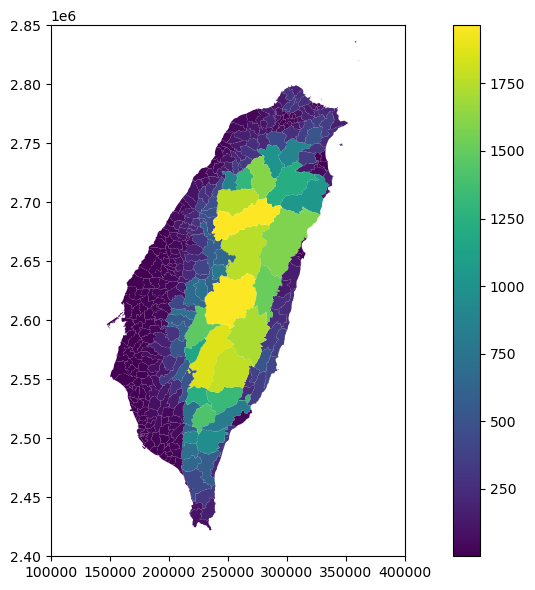

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
townships.plot(column='mean_elevation', ax=ax, legend=True)

# Specify coordinates for the plot
ax.set_xlim(100000, 400000)
ax.set_ylim(2400000, 2850000)

plt.tight_layout()
plt.show()

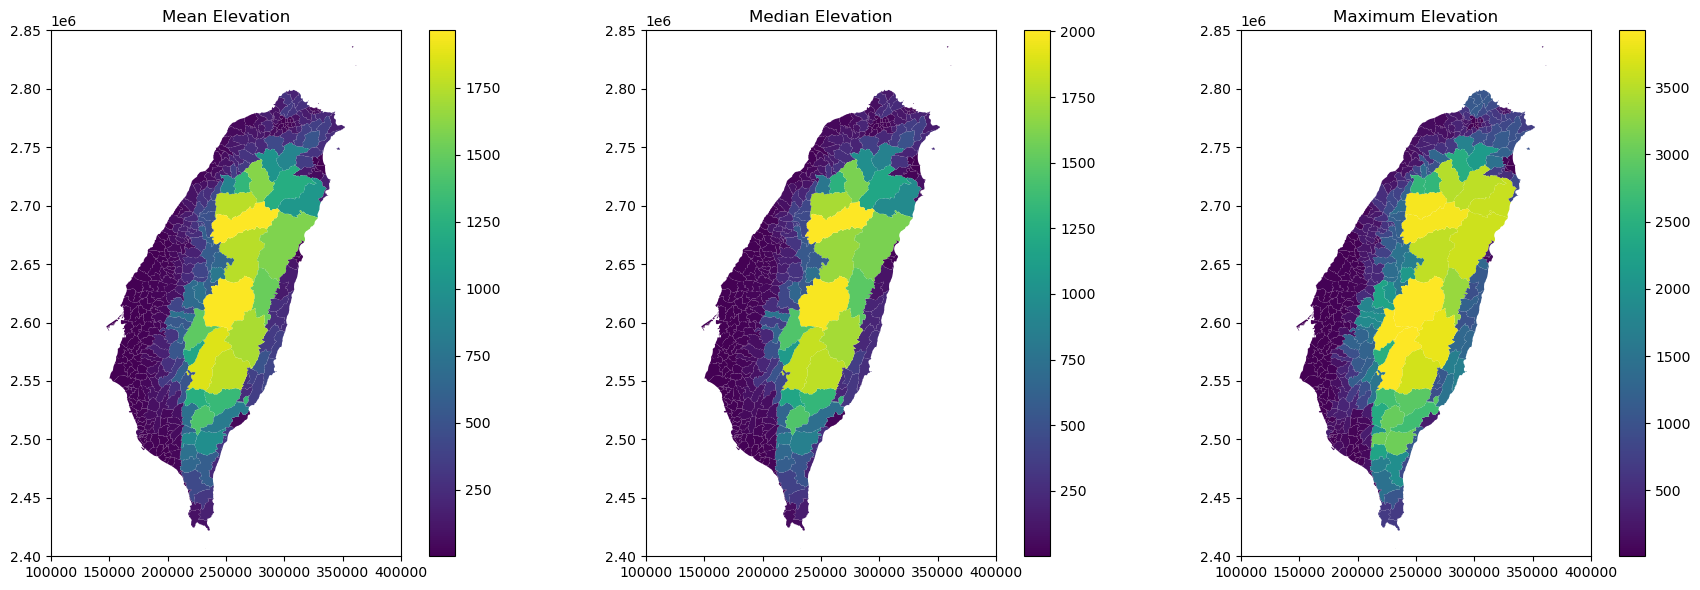

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

townships.plot(column='mean_elevation', ax=axs[0], legend=True)
axs[0].set_title('Mean Elevation')
axs[0].set_xlim(100000, 400000)
axs[0].set_ylim(2400000, 2850000)

townships.plot(column='median_elevation', ax=axs[1], legend=True)
axs[1].set_title('Median Elevation')
axs[1].set_xlim(100000, 400000)
axs[1].set_ylim(2400000, 2850000)

townships.plot(column='max_elevation', ax=axs[2], legend=True)
axs[2].set_title('Maximum Elevation')
axs[2].set_xlim(100000, 400000)
axs[2].set_ylim(2400000, 2850000)

plt.tight_layout()
plt.show()